In [ ]:
!pip install tensorflow-datasets

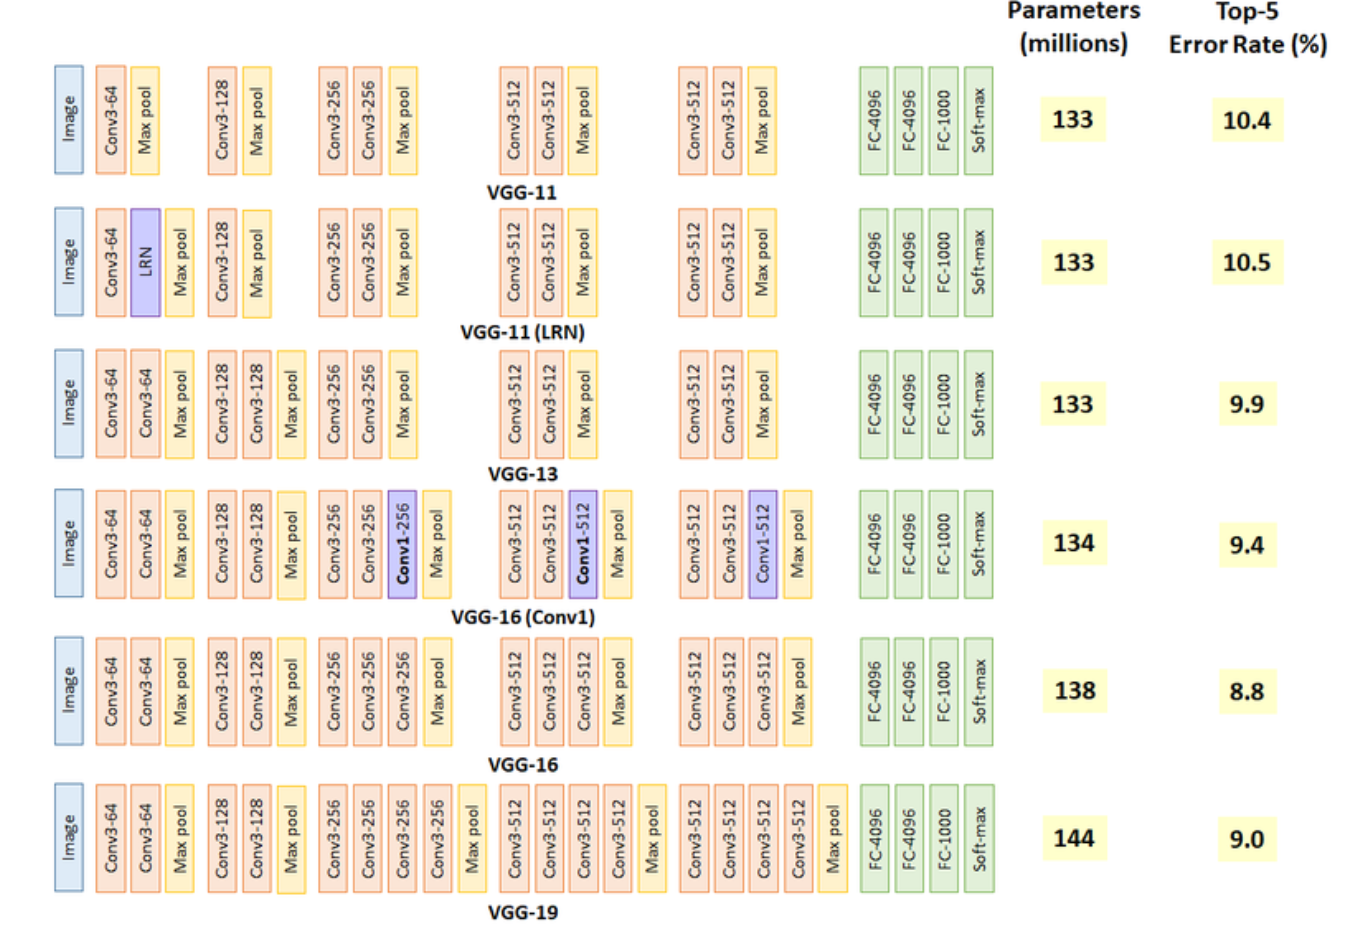

#📣 목차
- step1 import
- step2 데이터셋 준비하기
- step3 make VGG model
    - VGG 16
    - VGG 19
- step4 VGG16 과 VGG19 성능 비교

# step1 import

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow 가 활용할 GPU 가 있는지 확인하자
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#step2 데이터셋 준비하기

In [ ]:
# data load
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True, # 셔플을 할지말지, 
    with_info=True, # 
)
# ds_validation, split = ['trian','validation',test] 이렇게 설정하면 알아서 분리해서 가져와준다. 지금 노드에서는 2가지만 데리고 왔다

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete2IV7WY/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete2IV7WY/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorlow 데이터셋을 로드하면 feature 정보를 확인해보자
print(ds_info.features)

# 크기 32 X 32 X 3
# dictionary 이구나
# key 값을 통해서 value 를 가져온다

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터 개수를 확인해 보자
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label  
    # 2개가 들어와서 2개가 나가는 구나
    # cast 이미지를 변환을 시키구, label은 그대로 나간디.

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1 # map 을 시킬때 병렬적으로 시키는것, 가지고 있는 cpu  개수만큼 시키는게 제일 좋다
    )
    # 함수를 사용한 부분 ds.map(함수, ㅇㅇ)d
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat() # map 함수로 소비가 다 되도, 계속 사용하게 하는 것이다.
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # 이것을 하면 학습을 조금 빠르게 해준다. 
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

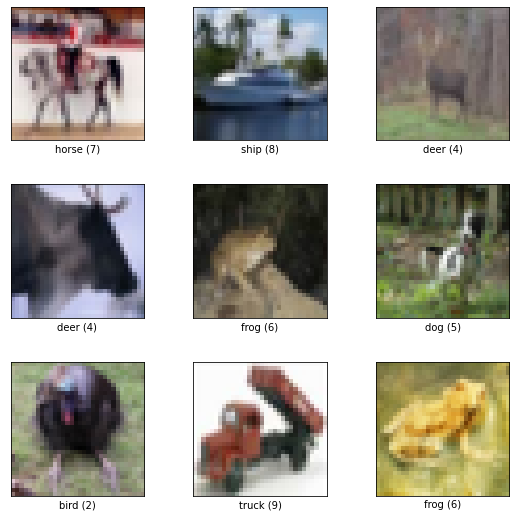

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)
# matplolib 을 해야하는데 tsdf 의 장점이다. 복잡하지 않게 볼 수 있다/

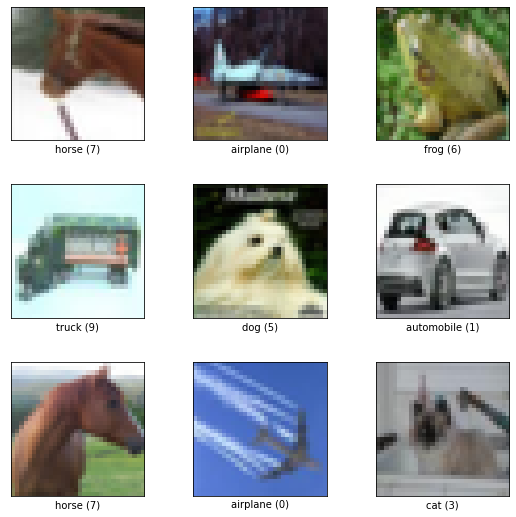

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

#step3  make VGG model
- 딥러닝 모델에서 주요 구조를 모듈화 시켜서 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라고 한다
- layer 는 기본적으로 tesnorflow, keras, pytorch 등에서 기본적으로 제공하는 단위이다.
- 여기서 우리는 **한 단계 위인 블록**을 단위모델로 만든다
### VGG
- VGG 블록은 개략적으로 CNN레이어 여러개와 Max pooling 레이어 한 개로 이루어 진다. CNN 모두 커널 크기가 3 X 3 라는 대표적인 특성을 가지고 있다


In [ ]:
# function for building VGG Block
# 계속 쌓는 레이어가 반복되기 떄문에, block 이라는것을 만들어서 쌓는다.

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # - 값이 안들어 왔을때 기본적으로 3으로 해야한다는 뜻이다. 


    # 입력 레이어
    x = input_layer

    # CNN 레이어
    # functional 방법으로 layer 을 쌓는 과정이다. (내가 이때까지 알았는던것 sequentail 방법)
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3), # - 필터 사이즈 
            activation='relu',
            kernel_initializer='he_normal',
            padding='same', # - x의 사이즈가 유지가 된다(same 이라고 두면),
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    # - 위에 입력 레이어가 들어간다, 

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2, # - 사이즈를 절반으로 줄여버린다는 것이다. 
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

## step3.1VGG 16

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    # buiding vgg block 을 5개로 구성된 것을 만들겠다는것을 집작할 수 있다
    
    assert len(cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    # assert 는 error를 발um_cnn생하하는 함수이다(python function)

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): # zip 두개의 list 를 묶어서 쌍으로 내보내 주는것. 쌍으로 묶기 위해서 쓴다 [ 2,64][2,128]
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
     # classfication 을 위한 모듈을 만드는 것이다, flatten, Dense, Dense, Dense 이 과정을 거친다   
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output) # 4096 이 대신 아무 숫자나 넣어도 된다. --> hidden layer 수를 4096개를 넣는다는 것이다. 
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)  
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg() # 함수의 출력값이 model 이다

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## step3.2 VGG 19

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

#step4 VGG16 과 VGG19 성능 비교

In [ ]:
BATCH_SIZE = 256 # 한번에 데이터를 몇개씩 학습할것인가
EPOCH = 15 # 5만개의 데이터를 몇번 볼것인가


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 31s 84ms/step - loss: 2.1993 - accuracy: 0.1833 - val_loss: 2.1112 - val_accuracy: 0.2140
Epoch 2/15
195/195 [==============================] - 16s 82ms/step - loss: 2.0333 - accuracy: 0.2643 - val_loss: 1.9304 - val_accuracy: 0.3154
Epoch 3/15
195/195 [==============================] - 16s 80ms/step - loss: 1.8949 - accuracy: 0.3208 - val_loss: 1.8140 - val_accuracy: 0.3553
Epoch 4/15
195/195 [==============================] - 16s 80ms/step - loss: 1.7841 - accuracy: 0.3584 - val_loss: 1.7386 - val_accuracy: 0.3800
Epoch 5/15
195/195 [==============================] - 15s 80ms/step - loss: 1.7028 - accuracy: 0.3908 - val_loss: 1.6900 - val_accuracy: 0.3904
Epoch 6/15
195/195 [==============================] - 15s 79ms/step - loss: 1.6343 - accuracy: 0.4178 - val_loss: 1.5554 - val_accuracy: 0.4426
Epoch 7/15
195/195 [==============================] - 16s 80ms/step - loss: 1.5728 - accuracy: 0.4369 - val_loss: 1.5635 - val_accuracy: 0.4563
Epo

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001), clipnorm=1.),metrics=['accuracy'],)# 무언가 기본값을 바꾸고 싶은때는 가지고 와서 설정해준다. # weight 를 업데이트 하는 방법 그게 optimizer 이다. (학습을 어떻게 시킬지 관련되어 있다)
    
    # metrics 이라는게 학습을 시킬때 결과값을 확인하고 싶은데(좋고 나쁨을) 그걸 지금 accuracy 를 한거다. 모델이 데이터를 넣었을떼 몇개를 맞추는가 precision 등등 있다.


history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE), # num_example = train size 의 개수이다. 256개의 이미지를 한번에 넣는다. 50000/256 = 몇번 학습을 시킬지195번 이 나온다
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,# 어떻게 결과를 보여줄것인가(비쥬얼 적인 부분이다)
    use_multiprocessing=True,
)
# compile 이라는것은 어떻게 학습을 시킬것인가 정의하는 부분이다.
# loss 를 어떻게 정의하느냐? (모델이 얼마나 나쁜지 어떻게 정의 하는가)
# svm loss, cross entropy loss, hinge loss 등등 task 에 따라서 어떤 loss 를 사용해야하는지 다르다. task 라 하면 classficatoin, regression, object dectection(오른쪽 위끝, 왼쪽 아래 끝) 등등

SyntaxError: ignored

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 23s 93ms/step - loss: 2.2427 - accuracy: 0.1528 - val_loss: 2.1567 - val_accuracy: 0.2135
Epoch 2/15
195/195 [==============================] - 18s 92ms/step - loss: 2.0594 - accuracy: 0.2410 - val_loss: 1.9649 - val_accuracy: 0.2784
Epoch 3/15
195/195 [==============================] - 18s 92ms/step - loss: 1.9369 - accuracy: 0.2881 - val_loss: 1.8858 - val_accuracy: 0.3128
Epoch 4/15
195/195 [==============================] - 18s 92ms/step - loss: 1.8221 - accuracy: 0.3399 - val_loss: 1.7302 - val_accuracy: 0.3729
Epoch 5/15
195/195 [==============================] - 18s 92ms/step - loss: 1.7151 - accuracy: 0.3799 - val_loss: 1.6479 - val_accuracy: 0.4075
Epoch 6/15
195/195 [==============================] - 18s 92ms/step - loss: 1.6512 - accuracy: 0.4018 - val_loss: 1.5856 - val_accuracy: 0.4345
Epoch 7/15
195/195 [==============================] - 18s 92ms/step - loss: 1.5931 - accuracy: 0.4251 - val_loss: 1.5675 - val_accuracy: 0.4252
Epo

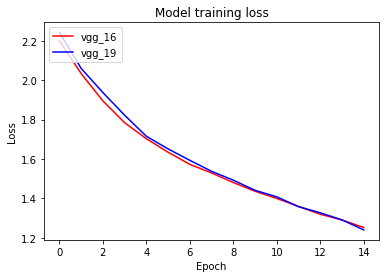

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# history,history 하면 dict 형태로 나오고 ['loss'] 라는 키값을 불러오는 것이다. 그리고  plt. plot 을 하면 그림을 그려준다

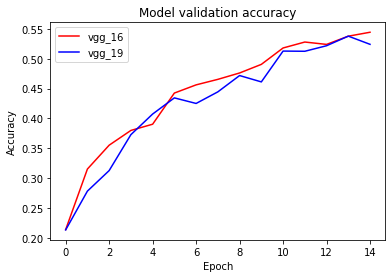

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [ ]:
# 모델 평가 --> 모델을 평가 한다는 것은 test data 로 하는것이다. 
# test data 로 evaluate 한것을 accuracy 라고 한다.


#model.evaluate(ds_test) # 이 과정이 평가 이다